# Trino 

This tutorial will show you how to get a Trino (f.k.a PrestoSQL) instance up and running locally to test JupySQL. You can run this in a Jupyter notebook.

## Pre-requisites

To run this tutorial, you need to install following Python packages:

In [1]:
%pip install jupysql trino pandas pyarrow --quiet

Note: you may need to restart the kernel to use updated packages.


You also need a Trino connector. Here is the [supported connector](https://pypi.org/project/sqlalchemy-trino/). You can install it with:

In [2]:
%pip install sqlalchemy-trino --quiet

Note: you may need to restart the kernel to use updated packages.


## Start Trino instance

We fetch the official image, create a new database, and user (this will take a few seconds).

In [1]:
%%bash
docker run -p 8080:8080 --name trino -d trinodb/trino

f9e0890fa2dea4de751347f4c6a4194dbbbdc7865535caeea0ae27e1f20245e0


Our database is running, let's load some data!

## Load sample data

Now, let's fetch some sample data. We'll be using the [NYC taxi dataset](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page):

In [4]:
import pandas as pd

df = pd.read_parquet(
    "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2021-01.parquet"
)
df.shape

(1369769, 19)

Trino has maximum query text length of 1000000. Therefore, writing the whole NYC taxi dataset (~1.4M rows) will throw errors. A workaround is to increase the [`http-server.max-request-size`](https://trino.io/docs/current/admin/properties-query-management.html#query-max-length) configuration parameter to Trino's maximum allowed characters of 1,000,000,000 in the Trino server configuration file (config.properties). We'll write a subset of the data instead:

In [5]:
df = df.head(1000)

Trino uses a schema named "default" to store tables. Therefore, `schema='default'` is required in the connection string.

In [6]:
from sqlalchemy import create_engine

engine = create_engine(
    "trino://user@localhost:8080/memory", connect_args={"user": "user"}
)

df.to_sql(
    con=engine,
    name="taxi",
    schema="default",
    method="multi",
    index=False,
)

engine.dispose()

/var/folders/r6/q0qh39ts70582wth4g1dhjhm0000gn/T/ipykernel_48433/191114213.py:3: SADeprecationWarning: The dbapi() classmethod on dialect classes has been renamed to import_dbapi().  Implement an import_dbapi() classmethod directly on class <class 'trino.sqlalchemy.dialect.TrinoDialect'> to remove this warning; the old .dbapi() classmethod may be maintained for backwards compatibility.
  engine = create_engine("trino://user@localhost:8080/memory", connect_args={"user": "user"})


## Query

Now, let's start JupySQL, authenticate, and query the data!

In [7]:
%load_ext sql

In [8]:
%sql trino://user@localhost:8080/memory

```{important}
If the cell above fails, you might have some missing packages. Message us on [Slack](https://ploomber.io/community) and we'll help you!
```

List the tables in the database:

In [9]:
%sqlcmd tables --schema default

Name
taxi


List columns in the taxi table:

In [10]:
%sqlcmd columns --table taxi --schema default

name,type,nullable,default
vendorid,BIGINT,True,None
tpep_pickup_datetime,TIMESTAMP,True,None
tpep_dropoff_datetime,TIMESTAMP,True,None
passenger_count,DOUBLE,True,None
trip_distance,DOUBLE,True,None
ratecodeid,DOUBLE,True,None
store_and_fwd_flag,VARCHAR,True,None
pulocationid,BIGINT,True,None
dolocationid,BIGINT,True,None
payment_type,BIGINT,True,None


Query our data:

In [11]:
%%sql
SELECT COUNT(*) FROM default.taxi

*  trino://user@localhost:8080/memory
Done.


_col0
1000


## Parameterize queries

In [12]:
threshold = 10

In [13]:
%%sql
SELECT COUNT(*) FROM default.taxi
WHERE trip_distance < {{threshold}}

*  trino://user@localhost:8080/memory
Done.


_col0
949


In [14]:
threshold = 0.5

In [15]:
%%sql
SELECT COUNT(*) FROM default.taxi
WHERE trip_distance < {{threshold}}

*  trino://user@localhost:8080/memory
Done.


_col0
64


## CTEs

In [16]:
%%sql --save many_passengers --no-execute
SELECT *
FROM default.taxi
WHERE passenger_count > 3
-- remove top 1% outliers for better visualization
AND trip_distance < 18.93

*  trino://user@localhost:8080/memory
Skipping execution...


In [17]:
%%sql --save trip_stats --with many_passengers
SELECT MIN(trip_distance), AVG(trip_distance), MAX(trip_distance)
FROM many_passengers

*  trino://user@localhost:8080/memory
Done.


_col0,_col1,_col2
0.25,3.16470588235294,11.15


This is what JupySQL executes:

In [18]:
query = %sqlrender trip_stats
print(query)

WITH many_passengers AS (
SELECT *
FROM default.taxi
WHERE passenger_count > 3
-- remove top 1% outliers for better visualization
AND trip_distance < 18.93)
SELECT MIN(trip_distance), AVG(trip_distance), MAX(trip_distance)
FROM many_passengers


## Plotting

The %sqlplot magic command currently does not directly support the `--schema` option for specifying the schema name. To work around this, you can specify the schema in the SQL query itself.

*  trino://user@localhost:8080/memory
Done.


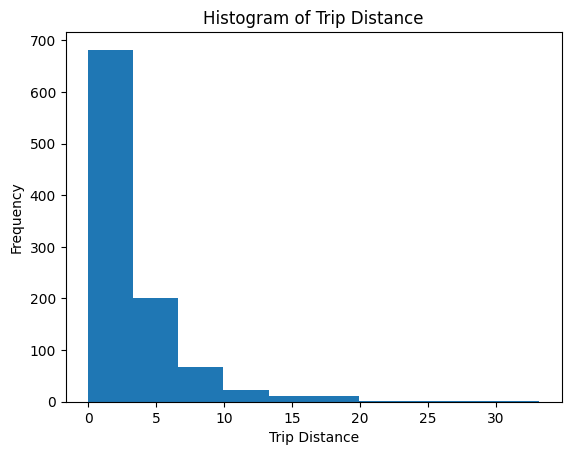

In [19]:
result = %sql SELECT trip_distance FROM default.taxi

import matplotlib.pyplot as plt

data = result.DataFrame()

plt.hist(data["trip_distance"])
plt.xlabel("Trip Distance")
plt.ylabel("Frequency")
plt.title("Histogram of Trip Distance")
plt.show()

*  trino://user@localhost:8080/memory
Done.


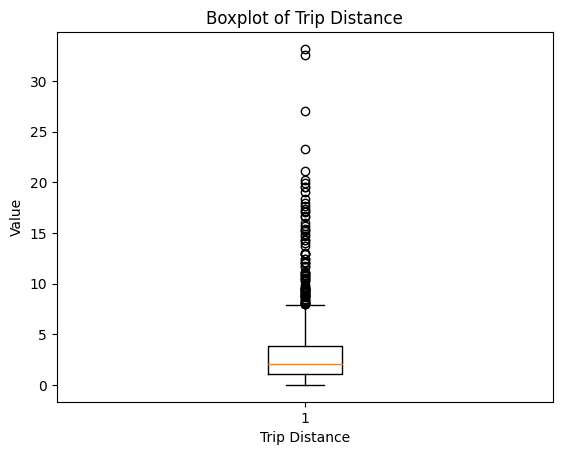

In [20]:
result = %sql SELECT trip_distance FROM default.taxi

import matplotlib.pyplot as plt

data = result.DataFrame()

plt.boxplot(data["trip_distance"])
plt.xlabel("Trip Distance")
plt.ylabel("Value")
plt.title("Boxplot of Trip Distance")
plt.show()

## Clean up

To stop and remove the container:

In [21]:
! docker container ls

CONTAINER ID   IMAGE           COMMAND                  CREATED          STATUS                    PORTS                    NAMES
819a48a82c7d   trinodb/trino   "/usr/lib/trino/bin/…"   33 seconds ago   Up 33 seconds (healthy)   0.0.0.0:8080->8080/tcp   trino


In [22]:
%%capture out
! docker container ls --filter ancestor=trinodb/trino --quiet

In [23]:
container_id = out.stdout.strip()
print(f"Container id: {container_id}")

Container id: 819a48a82c7d


In [24]:
! docker container stop {container_id}

819a48a82c7d


In [25]:
! docker container rm {container_id}

819a48a82c7d


In [26]:
! docker container ls

CONTAINER ID   IMAGE     COMMAND   CREATED   STATUS    PORTS     NAMES
